# Iris Flower - Batch Prediction


In this notebook we will, 

1. Load the batch inference data that arrived in the last 24 hours
2. Predict the first Iris Flower found in the batch
3. Write the ouput png of the Iris flower predicted, to be displayed in Github Pages.

In [68]:
import pandas as pd
import hopsworks
import joblib

project = hopsworks.login()
fs = project.get_feature_store()

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/696470
Connected. Call `.close()` to terminate connection gracefully.


In [ ]:
mr = project.get_model_registry()
model = mr.get_model("iris", version=1)
model_dir = model.download()
model = joblib.load(model_dir + "/iris_model.pkl")

We are downloading the 'raw' iris data. We explicitly do not want transformed data, reading for training. 

So, let's download the iris dataset, and preview some rows. 

Note, that it is 'tabular data'. There are 5 columns: 4 of them are "features", and the "variety" column is the **target** (what we are trying to predict using the 4 feature values in the target's row).

In [69]:
feature_view = fs.get_feature_view(name="iris", version=1)

Now we will do some **Batch Inference**. 

We will read all the input features that have arrived in the last 24 hours, and score them.

In [70]:
import datetime
from PIL import Image

batch_data = feature_view.get_batch_data()

y_pred = model.predict(batch_data)

y_pred

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.79s) 


array(['Setosa', 'Versicolor', 'Virginica', 'Versicolor', 'Setosa',
       'Versicolor', 'Virginica', 'Versicolor', 'Setosa', 'Setosa',
       'Setosa', 'Setosa', 'Virginica', 'Virginica', 'Setosa',
       'Virginica', 'Versicolor', 'Setosa', 'Versicolor', 'Versicolor',
       'Setosa', 'Versicolor', 'Setosa', 'Setosa', 'Versicolor',
       'Virginica', 'Virginica', 'Virginica', 'Versicolor', 'Versicolor',
       'Versicolor', 'Setosa', 'Setosa', 'Virginica', 'Setosa',
       'Virginica', 'Setosa', 'Versicolor', 'Virginica', 'Versicolor',
       'Virginica', 'Setosa', 'Versicolor', 'Virginica', 'Versicolor',
       'Setosa', 'Versicolor', 'Versicolor', 'Virginica', 'Setosa',
       'Setosa', 'Virginica', 'Virginica', 'Versicolor', 'Versicolor',
       'Virginica', 'Versicolor', 'Versicolor', 'Versicolor', 'Setosa',
       'Virginica', 'Virginica', 'Virginica', 'Setosa', 'Virginica',
       'Setosa', 'Versicolor', 'Versicolor', 'Setosa', 'Setosa', 'Setosa',
       'Virginica', 'Versicol

In [71]:
batch_data

,sepal_length,sepal_width,petal_length,petal_width
0,5.700000,3.800000,1.700000,0.300000
1,5.600000,2.700000,4.200000,1.300000
2,6.300000,3.300000,6.000000,2.500000
3,6.000000,2.900000,4.500000,1.500000
4,5.000000,3.000000,1.600000,0.200000
...,...,...,...,...
149,5.732203,2.366797,3.115597,1.155345
150,5.367117,4.434446,1.374910,0.497858
151,7.768135,3.645254,4.881264,1.835901
152,6.696777,3.204624,5.362983,1.098906


Batch prediction output is the last entry in the batch - it is output as a file 'latest_iris.png'

In [72]:
flower = y_pred[y_pred.size-1]
flower_img = "assets/" + flower + ".png"
img = Image.open(flower_img)            

img.save("../../assets/latest_iris.png")

In [73]:
iris_fg = fs.get_feature_group(name="iris", version=1)
df = iris_fg.read()
df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.77s) 


,sepal_length,sepal_width,petal_length,petal_width,variety
0,5.700000,3.800000,1.700000,0.300000,Setosa
1,5.600000,2.700000,4.200000,1.300000,Versicolor
2,6.300000,3.300000,6.000000,2.500000,Virginica
3,6.000000,2.900000,4.500000,1.500000,Versicolor
4,5.000000,3.000000,1.600000,0.200000,Setosa
...,...,...,...,...,...
149,5.732203,2.366797,3.115597,1.155345,Versicolor
150,5.367117,4.434446,1.374910,0.497858,Setosa
151,7.768135,3.645254,4.881264,1.835901,Virginica
152,6.696777,3.204624,5.362983,1.098906,Versicolor


In [74]:
label = df.iloc[-1]["variety"]
label

'Setosa'

In [75]:
label_flower = "assets/" + label + ".png"

img = Image.open(label_flower)            

img.save("../../assets/actual_iris.png")

In [76]:
import pandas as pd

monitor_fg = fs.get_or_create_feature_group(name="iris_predictions",
                                  version=1,
                                  primary_key=["datetime"],
                                  description="Iris flower Prediction/Outcome Monitoring"
                                 )

In [77]:
from datetime import datetime
now = datetime.now().strftime("%m/%d/%Y, %H:%M:%S")

data = {
    'prediction': [flower],
    'label': [label],
    'datetime': [now],
}
monitor_df = pd.DataFrame(data)
monitor_fg.insert(monitor_df)

Uploading Dataframe: 0.00% |          | Rows 0/1 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: iris_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/696470/jobs/named/iris_predictions_1_offline_fg_materialization/executions


(<hsfs.core.job.Job at 0x226a3d3dbe0>, None)

In [78]:
history_df = monitor_fg.read()
history_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.83s) 


,prediction,label,datetime
0,Setosa,Setosa,"05/10/2024, 08:04:17"
1,Setosa,Virginica,"05/10/2024, 13:47:48"
2,Setosa,Versicolor,"05/10/2024, 13:53:24"
3,Versicolor,Versicolor,"05/10/2024, 14:14:40"


In [79]:
import dataframe_image as dfi

df_recent = history_df.tail(5)

# If you exclude this image, you may have the same iris_latest.png and iris_actual.png files
# If no files have changed, the GH-action 'git commit/push' stage fails, failing your GH action (last step)
# This image, however, is always new, ensuring git commit/push will succeed.
dfi.export(df_recent, '../../assets/df_recent.png', table_conversion = 'matplotlib')

In [80]:
from sklearn.metrics import confusion_matrix

predictions = history_df[['prediction']]
labels = history_df[['label']]

results = confusion_matrix(labels, predictions)
print(results)

[[1 0 0]
 [1 1 0]
 [1 0 0]]


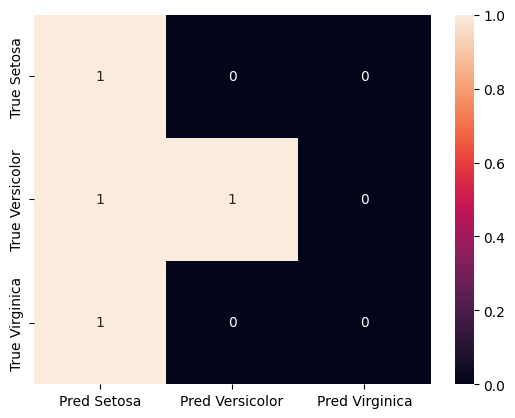

In [81]:
from matplotlib import pyplot
import seaborn as sns

# Only create the confusion matrix when our iris_predictions feature group has examples of all 3 iris flowers
if results.shape == (3,3):

    df_cm = pd.DataFrame(results, ['True Setosa', 'True Versicolor', 'True Virginica'],
                         ['Pred Setosa', 'Pred Versicolor', 'Pred Virginica'])

    cm = sns.heatmap(df_cm, annot=True)

    fig = cm.get_figure()
    fig.savefig("../../assets/confusion_matrix.png") 
    df_cm
else:
    print("Run the batch inference pipeline more times until you get 3 different iris flowers")    